# Generative Medical Image Segmentation

In [1]:
# --- Import Libraries ---
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.nn import PyroModule
from torch import nn
import sys
import os


sys.path.append(os.path.join(os.getcwd(), ".."))

from scripts.data import get_loaders
from scripts.funcs import run_model

# Define device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


# --- Set Plot Style ---
sns.set_style("dark")
plt.style.use("dark_background")


# --- Define Parameters ---
BATCH_SIZE = 64
IMG_SIZE = 32
NUM_WORKERS = 0

/opt/homebrew/Caskroom/miniconda/base/envs/MBML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Dataloaders

In [2]:
train_loader, test_loader = get_loaders("../data/", batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_workers=NUM_WORKERS)

Train set size: 3536
Test set size: 393


### Define Hierarchical VAE

In [3]:
class HierarchicalVAE(PyroModule):
    def __init__(self, input_dim, hidden_dim, latent_dims=[32, 16, 8]):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = IMG_SIZE * IMG_SIZE
        self.hidden_dim = hidden_dim
        self.latent_dims = latent_dims  # [z1_dim, z2_dim, z3_dim]
        L = len(latent_dims)

        # Bottom-up encoder backbone to compute shared features
        self.bottomup = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Per-layer deterministic features for encoder
        self.enc_features = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(L)
        ])

        # Top-down decoder backbone
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims[0], hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, self.output_dim),
            nn.Sigmoid()
        )

        # Generative priors p(z_l | z_{l+1:L})
        self.priors = nn.ModuleList()
        for i in range(L-1, -1, -1):
            if i == L-1:
                # Top latent layer prior ~ N(0, I)
                self.priors.append(None)
            else:
                # p(z_i | z_{i+1:L}) uses full stack of higher latents
                self.priors.append(
                    nn.Sequential(
                        nn.Linear(sum(latent_dims[i+1:]), hidden_dim),
                        nn.ReLU(),
                        nn.Linear(hidden_dim, 2 * latent_dims[i])  # mu and logvar
                    )
                )
        self.priors = nn.ModuleList(list(reversed(self.priors)))

        # Inference networks q(z_l | x, z_{l+1:L})
        self.posteriors = nn.ModuleList()
        for i in range(L-1, -1, -1):
            self.posteriors.append(
                nn.Sequential(
                    nn.Linear(hidden_dim + sum(latent_dims[i+1:]), hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, 2 * latent_dims[i])
                )
            )
        self.posteriors = nn.ModuleList(list(reversed(self.posteriors)))

    def model(self, x, y=None):
        pyro.module("hvae", self)
        batch_size = x.size(0)
        with pyro.plate("data", batch_size):
            zs = []

            # Top-level prior
            zL_dim = self.latent_dims[-1]
            zL = pyro.sample("z_3", dist.Normal(
                    torch.zeros(zL_dim, device=device),
                    torch.ones(zL_dim, device=device)
                ).to_event(1))
            
            zs.append(zL)

            # Remaining priors p(z_l | z_{l+1:L})
            for i in range(len(self.latent_dims)-2, -1, -1):
                h = torch.cat(zs, dim=-1)
                mu_logvar = self.priors[i](h)
                mu, logvar = mu_logvar.chunk(2, dim=-1)
                sigma = logvar.exp()
                z = pyro.sample(f"z_{i+1}", dist.Normal(mu, sigma).to_event(1))
                zs.insert(0, z)

            # Decode from z1
            yhat = self.decoder(zs[0])

            if y is not None:
                pyro.sample("obs", 
                            dist.Bernoulli(yhat, validate_args=False).to_event(1), 
                            obs=y.reshape(-1, self.output_dim),)
            else:
                pyro.deterministic("obs", yhat)

            return yhat
        
    def guide(self, x, y=None):
        pyro.module("hvae", self)
        batch_size = x.size(0)
        zs = {}
        with pyro.plate("data", batch_size):
            # Flatten input x from (3, IMG_SIZE, IMG_SIZE) to (input_dim)
            x_flat = x.view(batch_size, -1)
            # Bottom-up deterministic features
            h0 = self.bottomup(x_flat)
            features = [enc(h0) for enc in self.enc_features]

            # Top-down posterior q(z_L | x)
            L = len(self.latent_dims)
            i = L - 1
            feat = features[i]
            mu_logvar = self.posteriors[i](feat)
            mu, logvar = mu_logvar.chunk(2, dim=-1)
            sigma = logvar.exp()
            z = pyro.sample(f"z_{i+1}", dist.Normal(mu, sigma).to_event(1))
            zs[i] = z

            # Other layers q(z_l | x, z_{l+1:L})
            for i in range(L - 2, -1, -1):
                feat = features[i]
                parent_vec = torch.cat([zs[j] for j in range(i + 1, L)], dim=-1)
                inp = torch.cat([feat, parent_vec], dim=-1)
                mu_logvar = self.posteriors[i](inp)
                mu, logvar = mu_logvar.chunk(2, dim=-1)
                sigma = logvar.exp()
                z = pyro.sample(f"z_{i+1}", dist.Normal(mu, sigma).to_event(1))
                zs[i] = z
                
        return zs

In [5]:
# --- Training the VAE ---
num_epochs = 5
test_frequency = 10
lr = 1e-3

vae = HierarchicalVAE(input_dim=IMG_SIZE*IMG_SIZE*3, hidden_dim=800, latent_dims=[128, 64, 32])

# setup the optimizer
optimizer = Adam({"lr": lr})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

vae = run_model(vae, svi, train_loader, test_loader, num_epochs=num_epochs, test_frequency=test_frequency, device=device)

[Epoch 1]
Mean train loss: 88.6428
Mean test loss: 48.0762

[Epoch 2]
Mean train loss: 49.0185

[Epoch 3]
Mean train loss: 46.1117

[Epoch 4]
Mean train loss: 43.6431



KeyboardInterrupt: 

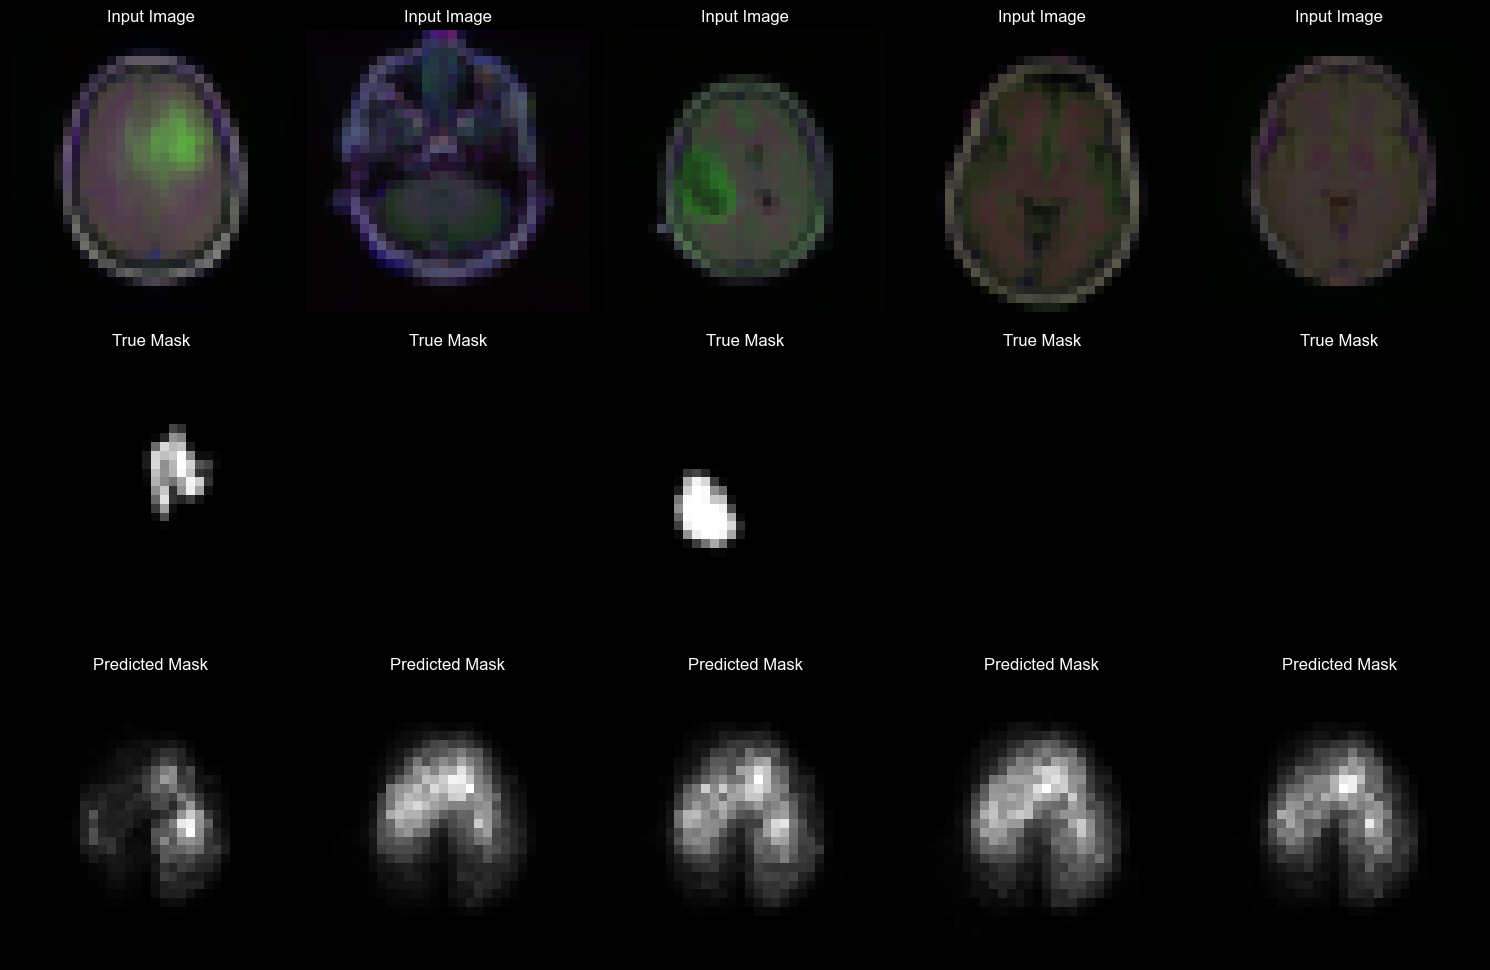

In [ ]:
def visualize_predictions(model, loader, num_images=5):
    model.eval()
    images, true_masks = next(iter(loader))
    images = images.to(device)
    true_masks = true_masks.to(device)
    with torch.no_grad():
        # Get model predictions and reshape to the mask dimensions
        pred = model.model(images, None)
    # Reshape predictions to match the true mask shape
    pred = pred.reshape(true_masks.size()).cpu().numpy()
    true_masks = true_masks.cpu().numpy()
    images = images.cpu().numpy()
    
    fig, axes = plt.subplots(3, num_images, figsize=(15, 10))
    for i in range(num_images):
         # Show input image
         axes[0, i].imshow(images[i].transpose(1, 2, 0))
         axes[0, i].set_title("Input Image")
         axes[0, i].axis("off")
         # Show true mask (using grayscale for clarity)
         axes[1, i].imshow(true_masks[i].transpose(1, 2, 0), cmap='gray')
         axes[1, i].set_title("True Mask")
         axes[1, i].axis("off")
         # Show predicted mask (using grayscale for clarity)
         axes[2, i].imshow(pred[i].transpose(1, 2, 0), cmap='gray')
         axes[2, i].set_title("Predicted Mask")
         axes[2, i].axis("off")
    plt.tight_layout()
    plt.show()


visualize_predictions(vae, test_loader)